In [1]:
import os
import pandas as pd
import numpy as np
import csv

from itertools import cycle, product
import argparse
import warnings

from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning

import nimfa

# import private scripts
import load_kmer_cnts_jf
import stats_utils_AEB

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/pollard/home/abustion/deep_learning_microbiome/scripts/stats_utils_AEB.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg') # this suppresses the console for plotting


In [2]:
graph_dir = os.environ['HOME'] + '/deep_learning_microbiome/analysis/kmers/linear/'

In [6]:
def vis_NMF(data, n_components=5, init = 'random', solver='mu', beta_loss='frobenius', max_iter=1000, random_state=0, sort = False, title = "dataset"):
    model = NMF(
        n_components = n_components,
        init = init,
        solver = solver, 
        beta_loss = beta_loss,
        max_iter = max_iter, 
        random_state = random_state
    )
    
    #NMF matrixes
    V = data.T
    W = model.fit_transform(V)
    H = model.components_
    print(W.shape)
    print(H.shape)
    
    #Getting it ready for plotting
    W_all = pd.DataFrame(W)
    W_all['Features'] = pd.read_csv(kmer_dir + str(kmer_size) + "mer_dictionary.gz", compression='gzip', header=None)
    
    #Plotting
    if sort == False:
        meltedW = pd.melt(W_all, id_vars = "Features", var_name='Signature (i.e. Factor)', value_name='Weight')
        sns.set(style="white")
        g = sns.FacetGrid(meltedW, row = 'Signature (i.e. Factor)', sharey = True, size = 7)
        g.map(sns.barplot, 'Features', 'Weight', color="blue", alpha = 0.7)
        g.set(xticklabels=[])
        plt.subplots_adjust(top=.93)
        g.fig.suptitle(title)
        plt.show()
        
    elif sort == True:
        meltedW = pd.melt(W_all, id_vars = "Features", var_name='Signature (i.e. Factor)', value_name='Weight').sort_values(by = 'Weight')
        sns.set(style="white")
        g = sns.FacetGrid(meltedW, row = 'Signature (i.e. Factor)', sharey = True, size = 7)
        g.map(sns.pointplot, 'Features', 'Weight', color='purple', alpha = 0.7)
        g.set(xticklabels=[])
        plt.subplots_adjust(top=.93)
        g.fig.suptitle(title)
        plt.show()

In [5]:
data_sets_to_use = [
    #[['MetaHIT'], ['MetaHIT']],                                                                                                                                                                
    #[['Qin_et_al'], ['Qin_et_al']],                                                                                                                                                            
    #[['Zeller_2014'], ['Zeller_2014']],                                                                                                                                                        
    [['LiverCirrhosis'], ['LiverCirrhosis']],                                                                                                                                                  
    #[['Karlsson_2013'], ['Karlsson_2013']],                                                                                                                                                    
    #[['RA'], ['RA']],                                                                                                                                                                          
    #[['Feng'], ['Feng']]
]

kmer_size = 5

for data_set in data_sets_to_use:
        data_set = data_set[0]
        kmer_dir = os.environ['HOME'] + '/deep_learning_microbiome/data/' + str(kmer_size) + 'mers_jf/'

        allowed_labels = ['0', '1']
        kmer_cnts, accessions, labelz, domain_labels = load_kmer_cnts_jf.load_kmers(kmer_size, data_set, allowed_labels)
        print("LOADED DATASET " + str(data_set[0]) + ": " + str(len(kmer_cnts)) + " SAMPLES")
        labelz=np.asarray(labelz)
        labelz=labelz.astype(np.int)

data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
data_normalized, labels = shuffle(data_normalized, labelz, random_state=0)

LiverCirrhosis
LOADED DATASET LiverCirrhosis: 232 SAMPLES


(512, 10)
(10, 232)


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


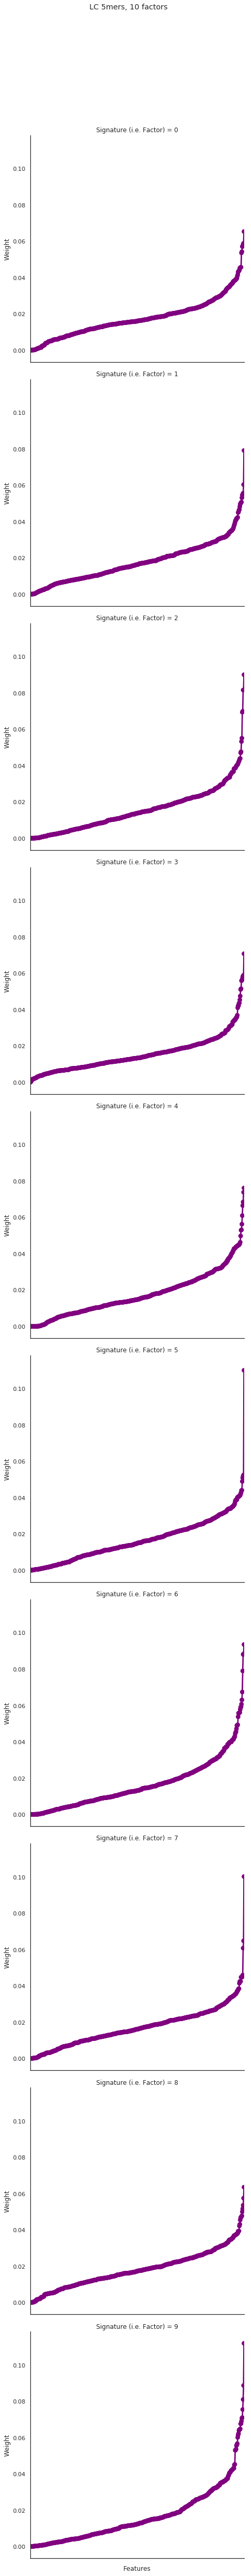

In [13]:
vis_NMF(data_normalized, n_components=10, sort = True, title="LC 5mers, 10 factors")

(512, 10)
(10, 232)


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


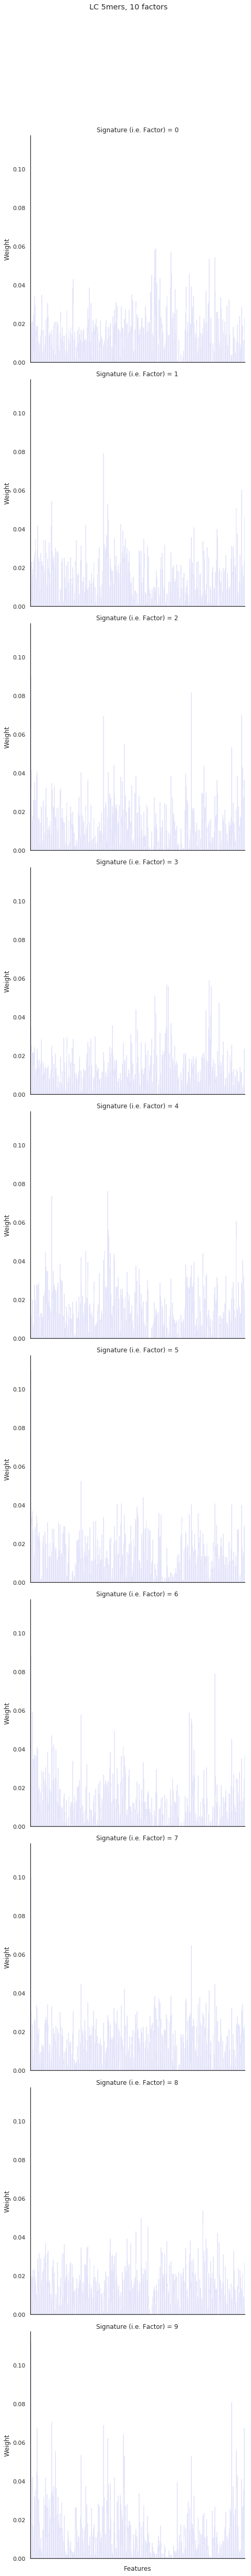

In [16]:
vis_NMF(data_normalized, n_components=10, sort = False, title="LC 5mers, 10 factors")

# text file output

In [87]:
def top_ten(dataset, kmer_size, n_factor):
    df = pd.read_pickle("/pollard/home/abustion/deep_learning_microbiome/data_AEB/pickled_dfs/['" +
                        dataset +
                        "']" +
                        str(kmer_size) +
                        "mers" + 
                        str(n_factor) +
                        "factors.pickle")
    
    df_output = pd.DataFrame()
    
    for signature in range(0, (n_factor)):
        top = df.loc[df['Signature (i.e. Factor)'] == signature].sort_values(by="Weight", ascending=False).head(n=10)
        df_output = df_output.append(top)
        
    df_output.to_csv("/pollard/home/abustion/deep_learning_microbiome/analysis/NMF/factor_identities/" +
                     dataset + '_' +
                     str(kmer_size) +
                     "mers_" + 
                     str(n_factor) +
                     "NMFfactors.txt", sep = '\t')    
    
    return df_output

In [84]:
top_ten('LiverCirrhosis', 5, 5)

,Features,Signature (i.e. Factor),Weight
0,AAAAA,0,0.164128
3,AAAAT,0,0.122170
480,TAAAA,0,0.106286
12,AAATA,0,0.099291
174,ATAAA,0,0.097234
47,AATAA,0,0.088358
50,AATAT,0,0.086711
15,AAATT,0,0.085283
384,GAAAA,0,0.084848
510,TTAAA,0,0.083684


In [91]:
for n in (5, 10, 20, 50):
    top_ten('LiverCirrhosis', kmer_size=10, n_factor=n)

In [103]:
def top_ten_for_grepping(dataset, kmer_size, n_factor):
    df = pd.read_pickle("/pollard/home/abustion/deep_learning_microbiome/data_AEB/pickled_dfs/['" +
                        dataset +
                        "']" +
                        str(kmer_size) +
                        "mers" + 
                        str(n_factor) +
                        "factors.pickle")
    
    df_output = pd.DataFrame()
    
    for signature in range(0, (n_factor)):
        top = df.loc[df['Signature (i.e. Factor)'] == signature].sort_values(by="Weight", ascending=False).head(n=10)
        df_output = df_output.append(top)
        
    
    df_output.to_csv("/pollard/home/abustion/deep_learning_microbiome/analysis/NMF/factor_identities/" +
                     dataset + '_' +
                     str(kmer_size) +
                     "mers_" + 
                     str(n_factor) +
                     "NMFfactors_for_grepping.txt", sep = '\t', index=False, header=False)  
                     
    df_output.reset_index(drop=True, inplace=True)
    
    return df_output

In [106]:
for n in (5, 10, 20, 50):
    top_ten_for_grepping('LiverCirrhosis', kmer_size=10, n_factor=n)

# delete later

In [114]:
df = pd.read_csv("/pollard/home/abustion/deep_learning_microbiome/data_AEB/LiverCirrhosis_PRJEB6337_run_accessions_only.txt",
                sep = '\t')

In [120]:
df.head()

,study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,sample_alias
0,PRJEB6337,SAMEA2581875,ERS475105,ERX491494,ERR526291,HD-1_Run4
1,PRJEB6337,SAMEA2581978,ERS475208,ERX492209,ERR527006,HV1_Run4
2,PRJEB6337,SAMEA2581979,ERS475209,ERX492210,ERR527007,HV10_Run4
3,PRJEB6337,SAMEA2581980,ERS475210,ERX492211,ERR527008,HV11_Run1
4,PRJEB6337,SAMEA2581981,ERS475211,ERX492212,ERR527009,HV11_Run4


In [111]:
df = df['run_accession']

In [113]:
df.to_csv("/pollard/home/abustion/deep_learning_microbiome/data_AEB/LiverCirrhosis_PRJEB6337_run_accessions_only.txt",
         index=False)

In [130]:
for file in os.listdir("/pollard/home/ngarud/shattuck/metagenomic_fastq_files/LiverCirrhosis/combined_fastq_files/"):
    print(file.split('_')[0])

HD-4
HV-3
HV-9
LD-89
LD-79
LD-49
HV-28
HV-18
LD-5
HD-39
LV-2
HD-33
LD-26
LD-16
LD-95
HD-80
LV-21
LV-11
LD-65
LD-55
LV-8
HD-70
HD-40
LD-30
HD-15
HD-25
LD-83
HD-56
HD-66
LD-43
LD-73
HV-12
HV-22
LD-88
LD-48
LD-78
HV-19
HV-29
LD-4
HD-38
LV-3
HD-32
LD-17
LD-27
LD-94
HD-81
LV-10
LV-20
LD-54
LD-64
HD-41
HD-71
LV-9
LD-31
HD-24
HD-14
LD-82
HD-67
HD-57
LD-72
LD-42
HV-23
HV-13
HD-5
HV-2
HV-8
LD-69
LD-59
LV-4
LD-3
HD-19
HD-29
HV-24
HV-14
LD-75
LD-45
HD-60
HD-50
LD-85
HD-23
HD-13
LD-36
HD-46
HD-76
LD-53
LD-63
LV-17
LD-93
LD-10
LD-20
HD-35
LD-9
HV-5
HD-2
HD-8
HV-4
HD-3
HD-9
LD-58
LD-68
LV-5
LD-2
LD-98
HD-28
HD-18
HV-15
HV-25
LD-44
LD-74
HD-51
HD-61
LD-84
HD-12
HD-22
LD-37
HD-77
HD-47
LD-62
LD-52
LV-16
LD-92
LD-21
LD-11
HD-34
LD-8
LD-7
LV-19
HD-78
HD-48
LD-38
LD-81
HD-27
HD-17
LD-32
LD-71
LD-41
HD-64
HD-54
HV-20
HV-10
HD-82
LD-97
LD-14
LD-24
HD-31
LV-13
LV-23
HD-42
HD-72
LD-57
LD-67
HD-6
HV-1
HD-7
LD-6
LV-18
HD-49
HD-79
LV-1
LD-39
LD-80
HD-16
HD-26
LD-33
LD-40
LD-70
HD-55
HD-65
HV-11
HV-21
HD-83
LD-9

# Beta-coefficient distributions

In [129]:
def beta_dist(data_sets, kmer_size, n_factor):

    # Loop over all data sets
    for data_set in data_sets:
        
        data_set = data_set[0]        
    
        # Retrieve diseased data and labels
        allowed_labels = ['0', '1']
        kmer_cnts, accessions, labelz, domain_labels = load_kmer_cnts_jf.load_kmers(kmer_size, data_set, allowed_labels)
        print("LOADED DATASET " + str(data_set[0]) + ": " + str(len(kmer_cnts)) + " SAMPLES")
        labelz=np.asarray(labelz)
        labelz=labelz.astype(np.int)
        
        # Conduct NMF and resave to data_normalized
        if n_factor == 0:
            data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
            data_normalized, labels = shuffle(data_normalized, labelz, random_state=0) 
            x = data_normalized
            y = labels
                    
        else:
            data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
            data_normalized = stats_utils_AEB.NMF_factor(data_normalized, kmer_size, n_components = int(n_factor), 
                                                     title=(str(data_set) + str(kmer_size) + "mers" 
                                                            + str(n_factor) + "factors"))
            data_normalized, labels = shuffle(data_normalized, labelz, random_state=0)
            x = data_normalized
            y = labels
            
        return x, y

In [131]:
data_sets = [
    #[['MetaHIT'], ['MetaHIT']],                                                                                                                                                                
    #[['Qin_et_al'], ['Qin_et_al']],                                                                                                                                                            
    #[['Zeller_2014'], ['Zeller_2014']],                                                                                                                                                        
    [['LiverCirrhosis'], ['LiverCirrhosis']],                                                                                                                                                  
    #[['Karlsson_2013'], ['Karlsson_2013']],                                                                                                                                                    
    #[['RA'], ['RA']],                                                                                                                                                                          
    #[['Feng'], ['Feng']]
]

In [151]:
x, y = beta_dist(data_sets, kmer_size=6, n_factor=80) 

LiverCirrhosis
LOADED DATASET LiverCirrhosis: 232 SAMPLES


In [152]:
k_fold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
estimator = LogisticRegressionCV(cv = k_fold, 
                                 scoring= 'accuracy', 
                                 max_iter = 1000,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 n_jobs = 1).fit(x,y)

/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/m

/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/m

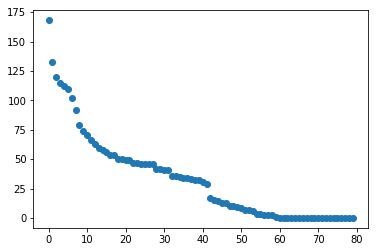

In [153]:
df = pd.DataFrame(abs(estimator.coef_)).T.sort_values(by = [0],axis=0, ascending=False).reset_index()
plt.scatter(y = df[0], x= df.index)
plt.show()

# Alexandrov 2A

In [3]:
data_sets = [
    #[['MetaHIT'], ['MetaHIT']],                                                                                                                                                                
    #[['Qin_et_al'], ['Qin_et_al']],                                                                                                                                                            
    [['Zeller_2014'], ['Zeller_2014']],                                                                                                                                                        
    #[['LiverCirrhosis'], ['LiverCirrhosis']],                                                                                                                                                  
    #[['Karlsson_2013'], ['Karlsson_2013']],                                                                                                                                                    
    #[['RA'], ['RA']],                                                                                                                                                                          
    #[['Feng'], ['Feng']]
]

In [4]:
def load_data(data_sets, kmer_size):
    
    # Loop over all data sets
    for data_set in data_sets:
        
        data_set = data_set[0]        
    
        # Retrieve diseased data and labels
        allowed_labels = ['0', '1']
        kmer_cnts, accessions, labelz, domain_labels = load_kmer_cnts_jf.load_kmers(kmer_size, data_set, allowed_labels)
        print("LOADED DATASET " + str(data_set[0]) + ": " + str(len(kmer_cnts)) + " SAMPLES")
        labelz=np.asarray(labelz)
        labelz=labelz.astype(np.int)
        data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
        
    
    return data_normalized, labelz

In [5]:
data, labels = load_data(data_sets, kmer_size=5)

Zeller_2014
LOADED DATASET Zeller_2014: 121 SAMPLES


In [113]:
data_set = ['Zeller_2014']
kmer_size = 5

In [114]:
allowed_labels = ['0', '1']
kmer_cnts, accessions, labelz, domain_labels = load_kmer_cnts_jf.load_kmers(kmer_size, data_set, allowed_labels)
print("LOADED DATASET " + str(data_set[0]) + ": " + str(len(kmer_cnts)) + " SAMPLES")
labelz=np.asarray(labelz)
labelz=labelz.astype(np.int)
data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')

Zeller_2014
LOADED DATASET Zeller_2014: 121 SAMPLES


# Using NIMFA

In [6]:
import matplotlib.gridspec as gridspec
import scipy.cluster.hierarchy as sch

In [8]:
V = data.T

In [29]:
nmf = nimfa.Nmf(V, max_iter=10, rank=2, track_error=True)

In [93]:
r = nmf.estimate_rank(rank_range=range(2,30))

In [102]:
r

{2: {'rank': 2,
  'sparseness': (0.14255114927391657, 0.06358625504189713),
  'rss': 0.008974328421596086,
  'evar': 0.9697119554599489,
  'residuals': matrix([[-7.67263922e-04, -3.53465857e-04, -6.48082046e-04, ...,
            4.41213488e-04,  1.30462079e-03, -9.92606459e-04],
          [-7.21943306e-04, -1.51925436e-04, -2.37575636e-04, ...,
            7.35766672e-04, -5.13465696e-05, -1.23908771e-04],
          [ 1.15429503e-03, -1.91814613e-04,  3.62025206e-04, ...,
           -1.24804574e-03,  1.21775300e-03, -2.12673987e-04],
          ...,
          [-5.78335204e-04,  9.19617534e-05, -1.12413929e-04, ...,
            1.73735854e-04,  3.72682509e-04, -1.55481978e-04],
          [-1.41407601e-03,  7.22272128e-05, -7.20172974e-04, ...,
            1.63153105e-03,  3.81332718e-04, -7.09174866e-04],
          [ 1.65597445e-04,  1.29330191e-04, -5.90610702e-05, ...,
           -1.60815786e-04,  1.66536331e-04, -1.66857065e-04]]),
  'connectivity': matrix([[1., 0., 1., ..., 0., 1., 0

In [95]:
result_array = []

In [96]:
for rank, vals in r.items():
    result_array.append([rank, vals['rss'], vals['cophenetic']])

In [97]:
result_array

[[2, 0.008974328421596086, 0.5034292413701417],
 [3, 0.009561866943027469, 0.45379376890875794],
 [4, 0.009781125496798104, 0.43585088958591867],
 [5, 0.009306117190921734, 0.4421820019708471],
 [6, 0.009508798346464516, 0.4298894975569791],
 [7, 0.009471890478746782, 0.42098133368355184],
 [8, 0.009009020723905798, 0.48992357902119826],
 [9, 0.009273896550454335, 0.450192369751771],
 [10, 0.008722938411393986, 0.45030425074418845],
 [11, 0.009034869567946701, 0.46129580069329135],
 [12, 0.008559419964846679, 0.5232141431672924],
 [13, 0.008728236897711013, 0.48262137378724024],
 [14, 0.009032177397977823, 0.46412178114870706],
 [15, 0.008541858124567037, 0.4761300181049564],
 [16, 0.008712738780091808, 0.45685111780029175],
 [17, 0.008556546463155849, 0.5152192396919358],
 [18, 0.007615318870359001, 0.5419384332225675],
 [19, 0.008111535002526376, 0.4899601485479304],
 [20, 0.008265162341896427, 0.5342035905409541],
 [21, 0.008176196555043617, 0.5522735028149167],
 [22, 0.007988203586

In [98]:
df = pd.DataFrame(result_array, columns=['rank', 'rss', 'coph'])

In [100]:
df.head()

,rank,rss,coph
0,2,0.008974,0.503429
1,3,0.009562,0.453794
2,4,0.009781,0.435851
3,5,0.009306,0.442182
4,6,0.009509,0.429889


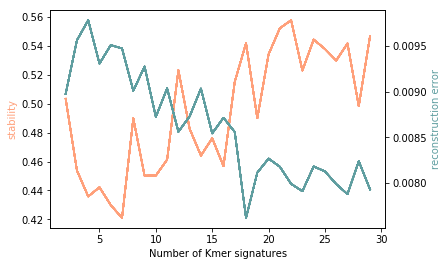

In [120]:
fig, ax1 = plt.subplots()
plt.xlabel('Number of Kmer signatures')
ax2 = ax1.twinx() 
ax1.set_ylabel('stability', color = 'lightsalmon')
ax2.set_ylabel('reconstruction error', color = 'cadetblue')
    
for i in df.iterrows():
    coph = df['coph']
    recon_err = df['rss']
    
    ax1.plot(df['rank'], coph, color = 'lightsalmon')
    ax2.plot(df['rank'], recon_err, color = 'cadetblue')

plt.show()

In [7]:
def alexandrov(data, max_factor):

    fig, ax1 = plt.subplots()
    plt.xlabel('Number of Kmer signatures')
    ax2 = ax1.twinx() 
    ax1.set_ylabel('stability', color = 'red')
    ax2.set_ylabel('reconstruction error', color = 'blue')
    
    for i in range(2, max_factor):
        nmf = nimfa.Nmf(
            data.T,
            rank = i,
            max_iter = 100,
            n_run = 50,
            track_factor = True
            )
        nmf_fit = nmf()
    
        sm = nmf_fit.summary()
        coph = sm['cophenetic']
        recon_err = sm['rss']
    
        ax1.scatter(i, coph, color = 'r')
        ax2.scatter(i, recon_err, color = 'b')
    
    plt.show()

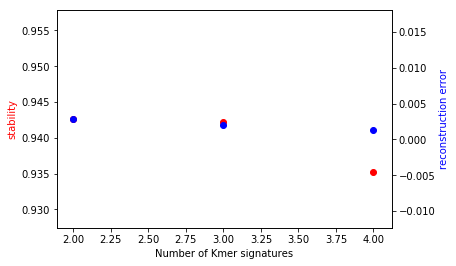

In [8]:
alexandrov(data, 5)

In [9]:
V = data.T

# Factorization will be run 3 times (n_run) and factors will be tracked for computing
# cophenetic correlation. Note increased time and space complexity
nmf = nimfa.Nmf(V, rank=5, seed='random_vcol', max_iter=100, 
                update='divergence', objective='div', n_run=50, track_factor=True)
nmf_fit = nmf()

sm = nmf_fit.summary()
print('Iterations: %d' % sm['n_iter'])
print('Cophenetic correlation: %5.3f' % sm['cophenetic'])

Iterations: 100
Cophenetic correlation: 0.926


In [10]:
sm

{'rank': 5,
 'sparseness': (0.19248384236459942, 0.11226834841774028),
 'rss': 0.0012761742494583979,
 'evar': 0.9956929565430828,
 'residuals': matrix([[ 5.57279180e-05, -4.88932762e-04,  2.19700926e-04, ...,
           8.29032716e-05, -1.28581448e-04,  8.24056473e-05],
         [ 1.37849616e-05, -2.71793964e-04,  6.99158769e-05, ...,
           1.68980257e-04, -1.91869602e-04,  8.67829114e-05],
         [ 9.99777424e-05, -2.91105972e-04,  2.34519788e-04, ...,
          -1.49306873e-04, -8.59833489e-06,  8.77856845e-05],
         ...,
         [ 8.11780252e-05, -3.81080964e-05,  1.14345778e-04, ...,
          -7.52249036e-05,  1.37149162e-04,  4.98582156e-06],
         [-2.70233234e-05, -7.22433425e-05,  2.30311816e-05, ...,
           5.38151278e-04, -7.53318109e-05, -6.68903846e-05],
         [ 5.26280020e-05,  5.86171447e-05, -6.88204421e-06, ...,
           1.94402994e-04, -3.21192411e-04,  5.41458545e-06]]),
 'connectivity': matrix([[1., 0., 0., ..., 0., 0., 0.],
         [0., 1.

In [13]:
r = nmf.estimate_rank(rank_range=[2,3,4], what=['rss'])
pp_r = '\n'.join('%d: %5.3f' % (rank, vals['rss']) for rank, vals in r.items())
print('Rank estimate:\n%s' % pp_r)

Rank estimate:
2: 0.003
3: 0.002
4: 0.001


# Cluster image

/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()


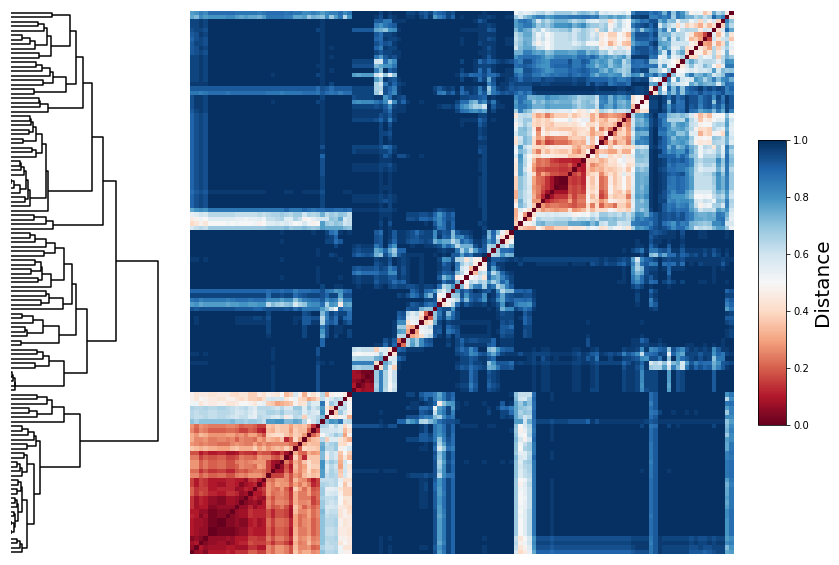

In [13]:
def clean_axis(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

fig = plt.figure(figsize=(13.9, 10))
heatmapGS = gridspec.GridSpec(1, 2, wspace=.01, hspace=0., width_ratios=[0.25,1])

C = 1 - nmf_fit.fit.consensus()
Y = sch.linkage(C, method='average')

denAX = fig.add_subplot(heatmapGS[0,0])
denD = sch.dendrogram(Y, orientation='right', link_color_func=lambda k: 'black')
clean_axis(denAX)

heatmapAX = fig.add_subplot(heatmapGS[0,1])
D = C[denD['leaves'], :][:, denD['leaves']]
axi = heatmapAX.imshow(D, interpolation='nearest', aspect='equal', origin='lower', cmap='RdBu') 
clean_axis(heatmapAX)

cb = fig.colorbar(axi, fraction=0.046, pad=0.04, aspect=10) 
cb.set_label('Distance', fontsize=20)